In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple


In [2]:
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

In [3]:
with open('/home/ubuntu/AffordanceNet/dataset/files/full_shape_train_data.pkl', 'rb') as f:
    affordance_net_data = pickle.load(f)

In [ ]:
len(affordance_net_data)

In [ ]:
affordance_net_data[0].keys()

In [ ]:
affordance_net_data[0]['affordance']

In [4]:
model_of_interest = affordance_net_data[3102]

In [ ]:
model_of_interest['semantic class']

In [ ]:
model_of_interest['full_shape']

In [5]:
model_of_interest['full_shape']['coordinate'].shape

(2048, 3)

In [ ]:
np.unique(model_of_interest['full_shape']['label']['sittable'])

In [6]:
def plot_point_cloud(point_cloud_array,color: bool = False, grid_size: int = 4,  
                     fixed_bounds: Optional[Tuple[Tuple[float, float, float], Tuple[float, float, float]]] = (
        (-0.75, -0.75, -0.75),
        (0.75, 0.75, 0.75)),affordance_array=None):
    """
    Render a point cloud as a plot to the given image path.

    :param pc: the PointCloud to plot.
    :param image_path: the path to save the image, with a file extension.
    :param color: if True, show the RGB colors from the point cloud.
    :param grid_size: the number of random rotations to render.
    """
    fig = plt.figure(figsize=(8, 8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax = fig.add_subplot(grid_size, grid_size, 1 + j + i * grid_size, projection="3d")
            color_args = {}
            color_args['c'] = []
            for p in affordance_array:
                if p > 0.2:
                    color_args['c'].append([1,0,0])
                else:
                    color_args['c'].append([0,0,1])
#             if color:
#                 color_args["c"] = np.stack(
#                     [pc.channels["R"], pc.channels["G"], pc.channels["B"]], axis=-1
#                 )
            c = point_cloud_array

            if grid_size > 1:
                theta = np.pi * 2 * (i * grid_size + j) / (grid_size**2)
                rotation = np.array(
                    [
                        [np.cos(theta), -np.sin(theta), 0.0],
                        [np.sin(theta), np.cos(theta), 0.0],
                        [0.0, 0.0, 1.0],
                    ]
                )
                c = c @ rotation

            ax.scatter(c[:, 0], c[:, 1], c[:, 2], **color_args)

            if fixed_bounds is None:
                min_point = c.min(0)
                max_point = c.max(0)
                size = (max_point - min_point).max() / 2
                center = (min_point + max_point) / 2
                ax.set_xlim3d(center[0] - size, center[0] + size)
                ax.set_ylim3d(center[1] - size, center[1] + size)
                ax.set_zlim3d(center[2] - size, center[2] + size)
            else:
                ax.set_xlim3d(fixed_bounds[0][0], fixed_bounds[1][0])
                ax.set_ylim3d(fixed_bounds[0][1], fixed_bounds[1][1])
                ax.set_zlim3d(fixed_bounds[0][2], fixed_bounds[1][2])

    return fig

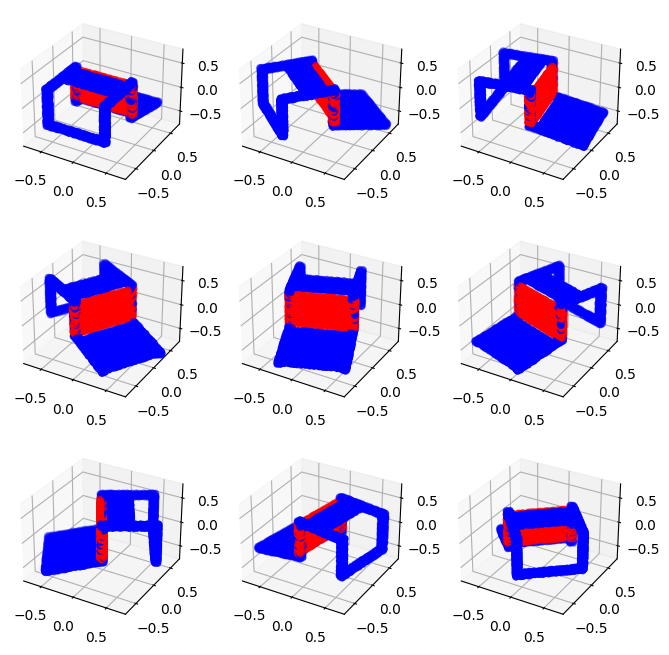

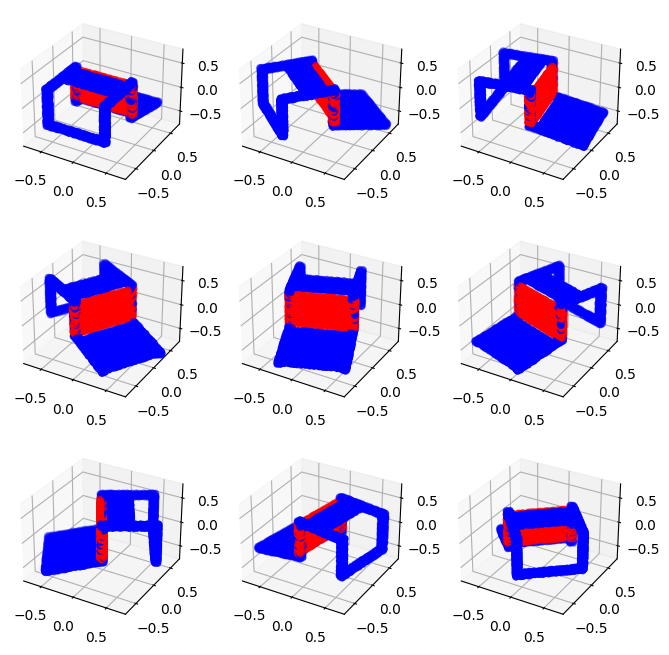

In [7]:
plot_point_cloud(affordance_net_data[3090]['full_shape']['coordinate'], grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), affordance_array=affordance_net_data[3090]['full_shape']['label']['sittable'])

In [ ]:
sittable_models = []
for index,element in enumerate(affordance_net_data):
    all_probs = element['full_shape']['label']['sittable']
    beyond_thresh = [val > 0.2 for val in all_probs]
    if(any(beyond_thresh)):
        sittable_models.append(index)

In [ ]:
len(sittable_models)

In [ ]:
affordance_models = {
}

In [ ]:
all_affordance_labels = ['grasp','contain','lift','openable','layable','support', 'sittable','wrap_grasp','pourable','move','displaY','pushable','pull','listen','wear','press','cut','stab']
for label in all_affordance_labels:
    for index,element in enumerate(affordance_net_data):
        all_probs = element['full_shape']['label'][label]
        all_coords = element['full_shape']['coordinate']
        beyond_thresh = [val > 0.2 for val in all_probs]
        if(not any(beyond_thresh)):
            continue
        segment_coords = []
        for coord,prob in zip(all_coords, all_probs):
            if(prob > 0.2):
                segment_coords.append(coord)
        segment_dict = {index: np.array(segment_coords)}
        # print(f'Completed Model: {index}')
        if(not label in affordance_models):
            affordance_models[label] = []
        affordance_models[label].append(segment_dict)
    print(f'Completed: {label}')

In [ ]:
len(affordance_models['sittable'])

In [ ]:
for element,list_e in affordance_models.items():
    print(f"{element} has {len(list_e)} shapes")

In [ ]:
plt.figure(figsize=(15,10))
for element,list_e in affordance_models.items():
    plt.bar(element,len(list_e), color='b')
plt.xticks(rotation=45)
plt.xlabel("Affordance Label")
plt.ylabel('Number of segments')
plt.savefig('count_affordance_segments.png')

In [ ]:
with open('affordance_segments.pickle', 'wb') as handle:
    pickle.dump(affordance_models, handle, protocol=pickle.HIGHEST_PROTOCOL)